In [1]:
import os
import json
import pandas as pd

annot_path="/kaggle/input/coco-2017-dataset/coco2017/annotations/captions_train2017.json"

with open(annot_path) as f:
    caption_data=json.load(f)

id_to_filename={img['id']:img['file_name'] for img in caption_data['images']}

image_captions=[]
for ann in caption_data['annotations']:
    image_id=ann['image_id']
    caption=ann['caption']
    image_filename=id_to_filename[image_id]
    image_path=os.path.join("/kaggle/input/coco-2017-dataset/coco2017/train2017",image_filename)
    image_captions.append((image_path,caption))

df=pd.DataFrame(image_captions,columns=['Image Path','Caption'])
print(df.head())

                                          Image Path  \
0  /kaggle/input/coco-2017-dataset/coco2017/train...   
1  /kaggle/input/coco-2017-dataset/coco2017/train...   
2  /kaggle/input/coco-2017-dataset/coco2017/train...   
3  /kaggle/input/coco-2017-dataset/coco2017/train...   
4  /kaggle/input/coco-2017-dataset/coco2017/train...   

                                             Caption  
0  A bicycle replica with a clock as the front wh...  
1  A room with blue walls and a white sink and door.  
2  A car that seems to be parked illegally behind...  
3  A large passenger airplane flying through the ...  
4  There is a GOL plane taking off in a partly cl...  


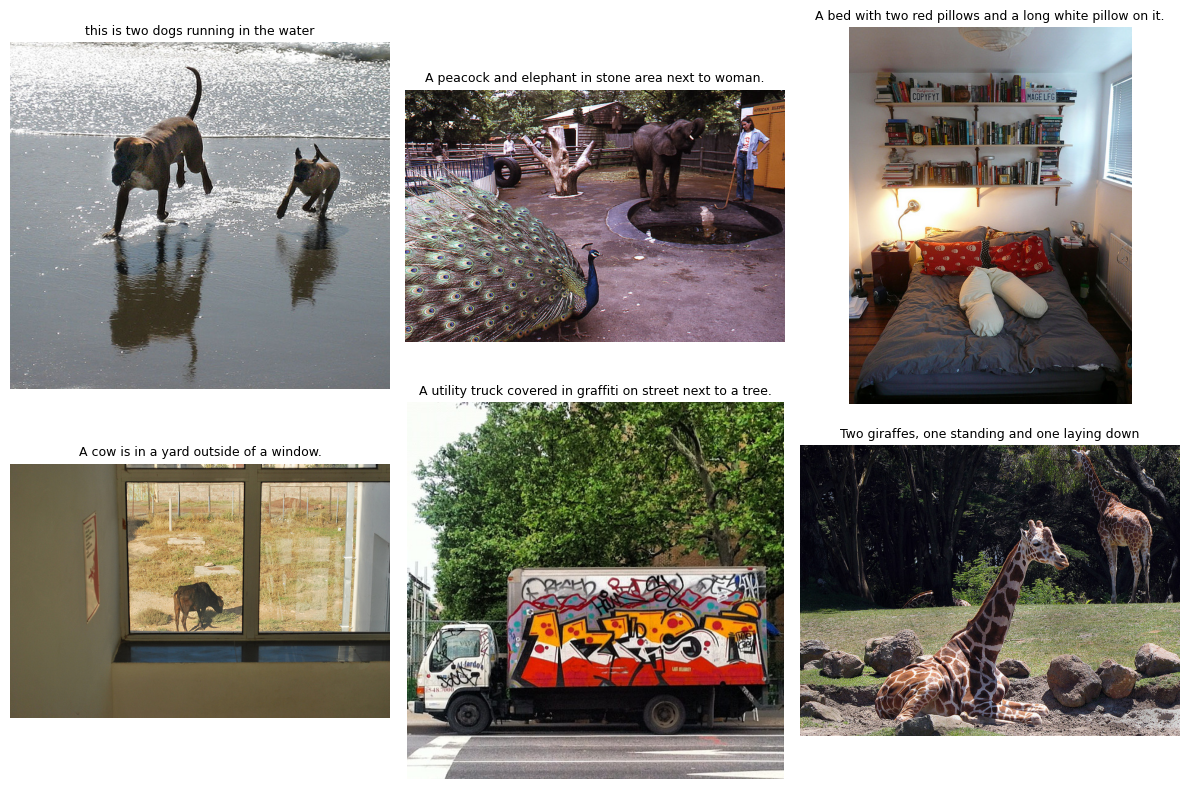

In [2]:
import matplotlib.pyplot as plt
import cv2
import random

plt.figure(figsize=(12,8))

for i in range(6):
    idx=random.randint(0,len(df)-1)
    row=df.iloc[idx]
    img=cv2.imread(row['Image Path'])
    img_rgb=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

    plt.subplot(2,3,i+1)
    plt.imshow(img_rgb)
    plt.title(row['Caption'],fontsize=9)
    plt.axis('off')

plt.tight_layout()
plt.show()

In [13]:
import re
from tensorflow.keras.preprocessing.text import Tokenizer

def clean_caption(caption):
    caption = caption.lower()
    caption = re.sub(r"[^a-zA-Z0-9]+", " ", caption)
    caption = caption.strip()
    return caption

df['caption_clean'] = df['Caption'].apply(lambda x: "startseq " + clean_caption(x) + " endseq")

print(df['caption_clean'].head())

tokenizer = Tokenizer(oov_token="<unk>", lower=False)
tokenizer.fit_on_texts(df['caption_clean'].tolist())

print("startseq" in tokenizer.word_index)
print("endseq" in tokenizer.word_index)

print("Token ID for start:", tokenizer.word_index.get("startseq"))
print("Token ID for end:", tokenizer.word_index.get("endseq"))


0    startseq a bicycle replica with a clock as the...
1    startseq a room with blue walls and a white si...
2    startseq a car that seems to be parked illegal...
3    startseq a large passenger airplane flying thr...
4    startseq there is a gol plane taking off in a ...
Name: caption_clean, dtype: object
True
True
Token ID for start: 3
Token ID for end: 4


In [14]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
from tqdm.notebook import tqdm

base_model=EfficientNetB0(include_top=False,weights='imagenet',pooling='avg')
model=Model(inputs=base_model.input,outputs=base_model.output)

def extract_features(image_paths):
    features={}
    try:
        for img_path in tqdm(image_paths):
            img=load_img(img_path,target_size=(224,224))
            img_array=img_to_array(img)
            img_array=np.expand_dims(img_array,axis=0)
            img_array=preprocess_input(img_array)
    
            features_vec=model.predict(img_array,verbose=0)
            features[img_path]=features_vec.squeeze()
    except:
        print(f"Failed to process {img_path}")
    return features

In [15]:
image_paths=df['Image Path'].unique()[:7500]
image_features=extract_features(image_paths)

key=list(image_features.keys())[0]
print("Image path:",key)
print("Feature shape:",image_features[key].shape)

  0%|          | 0/7500 [00:00<?, ?it/s]

Image path: /kaggle/input/coco-2017-dataset/coco2017/train2017/000000203564.jpg
Feature shape: (1280,)


In [16]:
vocab_size=len(tokenizer.word_index)+1
embedding_dim=256
lstm_units=256

from tensorflow.keras.layers import Input,Dense,Embedding,LSTM,Dropout,Concatenate,RepeatVector
from tensorflow.keras.models import Model

img_input=Input(shape=(1280,),name='img_input')
img_dense=Dense(embedding_dim,activation='relu')(img_input)
image_repeated=RepeatVector(max_len)(img_dense)

caption_input=Input(shape=(None,),name='caption_input')
caption_embed=Embedding(input_dim=vocab_size,output_dim=embedding_dim)(caption_input)

merge=Concatenate(axis=-1)([image_repeated,caption_embed])
lstm_output=LSTM(lstm_units)(merge)

output=Dense(vocab_size,activation='softmax')(lstm_output)

model=Model(inputs=[img_input, caption_input], outputs=output)
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam')

model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ img_input (InputLayer)    │ (None, 1280)           │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 256)            │        327,936 │ img_input[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ caption_input             │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ repeat_vector_1           │ (None, 52, 256)        │              0 │ dense_2[0][0]          │
│ (RepeatVector)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_1 (Embedding)   │ (None, None, 256)      │      6,874,112 │ caption_input[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 52, 512)        │              0 │ repeat_vector_1[0][0], │
│ (Concatenate)             │                        │                │ embedding_1[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_1 (LSTM)             │ (None, 256)            │        787,456 │ concatenate_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 26852)          │      6,900,964 │ lstm_1[0][0]           │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 14,890,468 (56.80 MB)

 Trainable params: 14,890,468 (56.80 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
train_df=df[df['Image Path'].isin(image_features.keys())]

X_img,X_seq,y=[],[],[]

for _,row in train_df.iterrows():
    img_path = row['Image Path']
    seq = tokenizer.texts_to_sequences([row['caption_clean']])[0]
    
    for i in range(1, len(seq)):
        in_seq=seq[:i]
        out_word=seq[i]
        in_seq_padded=pad_sequences([in_seq],maxlen=max_len,padding='post')[0]
        X_img.append(image_features[img_path])
        X_seq.append(in_seq_padded)
        y.append(out_word)


X_img=np.array(X_img)
X_seq=np.array(X_seq)
y=np.array(y).reshape(-1, 1)

print("Shapes:")
print("X_img:",X_img.shape)
print("X_seq:",X_seq.shape)
print("y:",y.shape)

Shapes:
X_img: (429223, 1280)
X_seq: (429223, 52)
y: (429223, 1)


In [18]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint('best_caption_model.h5', save_best_only=True, monitor='loss', mode='min')
history = model.fit(
    [X_img, X_seq], y,
    batch_size=256,
    epochs=20,
    callbacks=[checkpoint],
    verbose=1
)

Epoch 1/20
1677/1677 ━━━━━━━━━━━━━━━━━━━━ 60s 34ms/step - loss: 5.6206
Epoch 2/20
1677/1677 ━━━━━━━━━━━━━━━━━━━━ 58s 34ms/step - loss: 4.8105
Epoch 3/20
1677/1677 ━━━━━━━━━━━━━━━━━━━━ 58s 34ms/step - loss: 4.4812
Epoch 4/20
1677/1677 ━━━━━━━━━━━━━━━━━━━━ 58s 34ms/step - loss: 4.1827
Epoch 5/20
1677/1677 ━━━━━━━━━━━━━━━━━━━━ 58s 35ms/step - loss: 3.7407
Epoch 6/20
1677/1677 ━━━━━━━━━━━━━━━━━━━━ 58s 35ms/step - loss: 3.3591
Epoch 7/20
1677/1677 ━━━━━━━━━━━━━━━━━━━━ 58s 35ms/step - loss: 3.0969
Epoch 8/20
1677/1677 ━━━━━━━━━━━━━━━━━━━━ 58s 35ms/step - loss: 2.8844
Epoch 9/20
1677/1677 ━━━━━━━━━━━━━━━━━━━━ 58s 35ms/step - loss: 2.7289
Epoch 10/20
1677/1677 ━━━━━━━━━━━━━━━━━━━━ 58s 35ms/step - loss: 2.6040
Epoch 11/20
1677/1677 ━━━━━━━━━━━━━━━━━━━━ 58s 35ms/step - loss: 2.4957
Epoch 12/20
1677/1677 ━━━━━━━━━━━━━━━━━━━━ 58s 35ms/step - loss: 2.3960
Epoch 13/20
1677/1677 ━━━━━━━━━━━━━━━━━━━━ 58s 34ms/step - loss: 2.3250
Epoch 14/20
1677/1677 ━━━━━━━━━━━━━━━━━━━━ 58s 35ms/step - loss: 2.2513
E

In [19]:
def generate_caption_greedy(model, tokenizer, image_feature, max_length):
    in_text = 'startseq'
    
    for _ in range(max_length):
        
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length, padding='post')

        yhat = model.predict([image_feature.reshape(1, 1280), sequence], verbose=0)
        yhat = np.argmax(yhat[0])

        
        if yhat == tokenizer.word_index['endseq']:
            break

        word = tokenizer.index_word.get(yhat, '<unk>')
        in_text += ' ' + word

    return in_text.replace('startseq', '').strip()

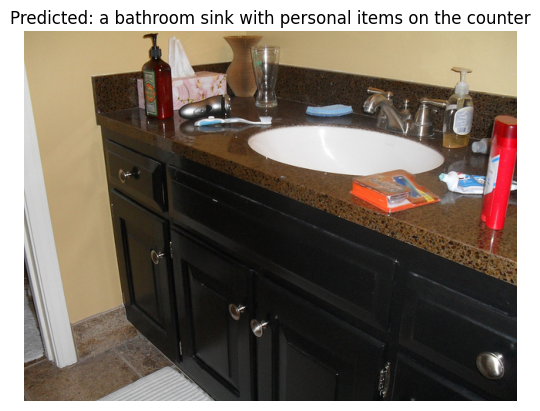

In [20]:
import random
random_path = random.choice(list(image_features.keys()))
random_feature = image_features[random_path]

caption = generate_caption_greedy(model,tokenizer,random_feature,max_len)

import cv2
import matplotlib.pyplot as plt

img = cv2.imread(random_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.axis('off')
plt.title("Predicted: " + caption)
plt.show()

In [21]:
!pip install pycocotools --quiet

In [26]:
import os
from pycocotools.coco import COCO

data_dir="/kaggle/input/coco-2017-dataset/coco2017"
image_dir="/kaggle/input/coco-2017-dataset/coco2017/train2017"
ann_dir="/kaggle/input/coco-2017-dataset/coco2017/annotations/instances_train2017.json"

coco=COCO(ann_dir)

loading annotations into memory...
Done (t=19.00s)
creating index...
index created!


In [38]:
import torch
from torch.utils.data import Dataset
from PIL import Image
import numpy as np

class CocoInstanceDataset(Dataset):
    def __init__(self,image_dir,ann_dir,transforms=None):
        self.image_dir=image_dir
        self.coco=COCO(ann_dir)
        self.image_ids=list(self.coco.imgs.keys())
        self.transforms=transforms

    def __getitem__(self,idx):
        image_id = self.image_ids[idx]
        img_info = self.coco.loadImgs(image_id)[0]
        path = img_info['file_name']
        img_path = os.path.join(self.image_dir, path)
    
        try:
            img = Image.open(img_path).convert("RGB")
        except:
            # Image could not be loaded
            return self.__getitem__((idx + 1) % len(self))
    
        # Get annotations
        ann_ids = self.coco.getAnnIds(imgIds=image_id)
        anns = self.coco.loadAnns(ann_ids)
    
        masks, boxes, labels = [], [], []
    
        for ann in anns:
            if 'segmentation' in ann and ann.get('iscrowd', 0) == 0 and ann['area'] > 0:
                mask = self.coco.annToMask(ann)
                if mask.sum() > 0:
                    masks.append(mask)
                    x, y, w, h = ann['bbox']
                    boxes.append([x, y, x + w, y + h])
                    labels.append(ann['category_id'])
    
        if len(masks) == 0:
            # Try next image if no valid masks
            return self.__getitem__((idx + 1) % len(self))
    
        # Prepare tensors
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        masks = torch.as_tensor(np.stack(masks), dtype=torch.uint8)
    
        target = {
            'boxes': boxes,
            'labels': labels,
            'masks': masks,
            'image_id': torch.tensor([image_id])
        }
    
        if self.transforms:
            img = self.transforms(img)
    
        return img, target

    
    def __len__(self):
        return len(self.image_ids)

loading annotations into memory...
Done (t=18.04s)
creating index...
index created!


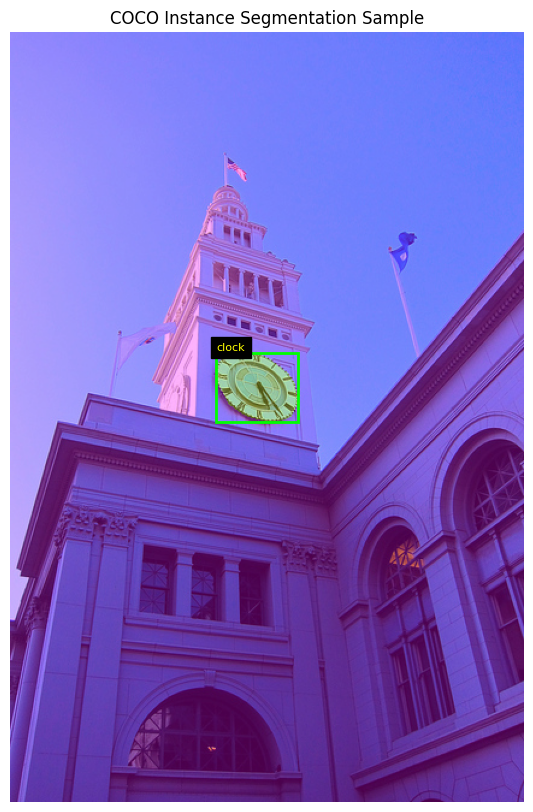

In [39]:
import matplotlib.pyplot as plt
import torchvision.transforms as T
import random
from matplotlib.patches import Rectangle

# Load category ID to name mapping
coco_categories = coco.loadCats(coco.getCatIds())
cat_id_to_name = {cat['id']: cat['name'] for cat in coco_categories}

# Transform to convert image to tensor
transform = T.ToTensor()

# Reload dataset with transform
dataset = CocoInstanceDataset(image_dir, ann_dir, transforms=transform)

# Pick a random index
idx = random.randint(0, len(dataset) - 1)
img_tensor, target = dataset[idx]

# Convert tensor image to numpy
img = img_tensor.permute(1, 2, 0).numpy()

# Create plot
plt.figure(figsize=(10, 10))
plt.imshow(img)
ax = plt.gca()

# Draw bounding boxes and masks
for i in range(len(target['boxes'])):
    box = target['boxes'][i]
    label = target['labels'][i].item()
    mask = target['masks'][i].numpy()

    # Draw bbox
    x1, y1, x2, y2 = box
    rect = Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2, edgecolor='lime', facecolor='none')
    ax.add_patch(rect)

    # Label text
    label_name = cat_id_to_name.get(label, 'unknown')
    plt.text(x1, y1 - 2, label_name, color='yellow', fontsize=8, backgroundcolor='black')

    # Overlay mask
    plt.imshow(mask, alpha=0.3, cmap='spring')

plt.axis('off')
plt.title("COCO Instance Segmentation Sample")
plt.show()

In [40]:
from torch.utils.data import DataLoader

# Use a subset to train quickly (e.g., 200 images)
subset_indices = list(range(200))
subset_dataset = torch.utils.data.Subset(dataset, subset_indices)

# Collate function
def collate_fn(batch):
    return tuple(zip(*batch))

data_loader = DataLoader(
    subset_dataset,
    batch_size=2,
    shuffle=True,
    num_workers=2,
    collate_fn=collate_fn
)

In [41]:
import torch
import torchvision

# Use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load pretrained Mask R-CNN
model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
model.to(device)
model.train()

# Optimizer and LR scheduler
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth
100%|██████████| 170M/170M [00:00<00:00, 206MB/s]  


In [42]:
num_epochs = 5

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0

    for batch_idx, (images, targets) in enumerate(data_loader):
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # Forward pass
        loss_dict = model(images, targets)
        total_loss = sum(loss for loss in loss_dict.values())

        # Backprop
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        epoch_loss += total_loss.item()

        if batch_idx % 10 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}] Batch [{batch_idx}] Loss: {total_loss.item():.4f}")

    lr_scheduler.step()
    print(f"Epoch [{epoch+1}] Total Loss: {epoch_loss:.4f}")

Epoch [1/5] Batch [0] Loss: 0.9232
Epoch [1/5] Batch [10] Loss: 0.5390
Epoch [1/5] Batch [20] Loss: 1.2853
Epoch [1/5] Batch [30] Loss: 1.1472
Epoch [1/5] Batch [40] Loss: 1.3202
Epoch [1/5] Batch [50] Loss: 0.6479
Epoch [1/5] Batch [60] Loss: 0.7872
Epoch [1/5] Batch [70] Loss: 0.9275
Epoch [1/5] Batch [80] Loss: 0.8264
Epoch [1/5] Batch [90] Loss: 0.9879
Epoch [1] Total Loss: 99.5810
Epoch [2/5] Batch [0] Loss: 1.3043
Epoch [2/5] Batch [10] Loss: 0.8837
Epoch [2/5] Batch [20] Loss: 0.9808
Epoch [2/5] Batch [30] Loss: 0.5490
Epoch [2/5] Batch [40] Loss: 0.3637
Epoch [2/5] Batch [50] Loss: 1.3435
Epoch [2/5] Batch [60] Loss: 0.5125
Epoch [2/5] Batch [70] Loss: 1.1915
Epoch [2/5] Batch [80] Loss: 0.2539
Epoch [2/5] Batch [90] Loss: 0.6858
Epoch [2] Total Loss: 81.2866
Epoch [3/5] Batch [0] Loss: 0.4217
Epoch [3/5] Batch [10] Loss: 0.5059
Epoch [3/5] Batch [20] Loss: 0.5589
Epoch [3/5] Batch [30] Loss: 1.0143
Epoch [3/5] Batch [40] Loss: 0.5276
Epoch [3/5] Batch [50] Loss: 0.9633
Epoch [

In [43]:
torch.save(model.state_dict(), "maskrcnn_finetuned_coco.pth")

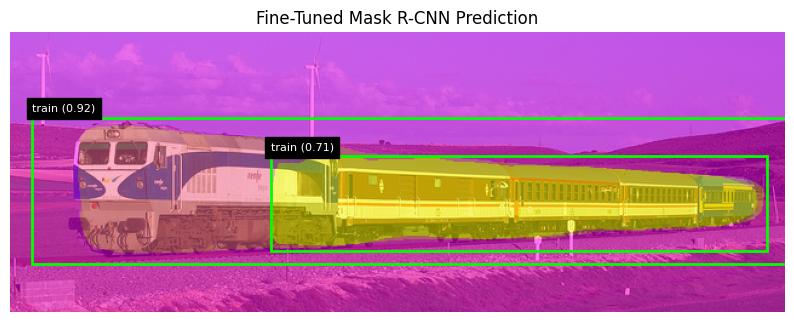

In [44]:
model.eval()  # Important: switch to inference mode again
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# Pick a random image from the dataset
import random
img_tensor, _ = dataset[random.randint(0, len(dataset) - 1)]
img = img_tensor.to(device)

# Inference
with torch.no_grad():
    prediction = model([img])[0]

# Convert image to displayable format
img_np = img.cpu().permute(1, 2, 0).numpy()
plt.figure(figsize=(10, 10))
plt.imshow(img_np)
ax = plt.gca()

for i in range(len(prediction["boxes"])):
    score = prediction["scores"][i].item()
    if score < 0.7:
        continue

    box = prediction["boxes"][i].cpu().numpy()
    label_id = prediction["labels"][i].item()
    mask = prediction["masks"][i, 0].cpu().numpy()
    label_name = cat_id_to_name.get(label_id, "unknown")

    x1, y1, x2, y2 = box
    rect = Rectangle((x1, y1), x2 - x1, y2 - y1,
                     linewidth=2, edgecolor='lime', facecolor='none')
    ax.add_patch(rect)
    plt.text(x1, y1 - 5, f"{label_name} ({score:.2f})",
             color='white', fontsize=8, backgroundcolor='black')

    plt.imshow(mask > 0.5, alpha=0.3, cmap='spring')

plt.axis('off')
plt.title("Fine-Tuned Mask R-CNN Prediction")
plt.show()

In [53]:
def caption_and_segment(image_path, model_caption, tokenizer, model_segmentation, device, max_length):
    import cv2
    import matplotlib.pyplot as plt
    from matplotlib.patches import Rectangle
    import numpy as np
    import torchvision.transforms as T
    from tensorflow.keras.applications import EfficientNetB0
    from tensorflow.keras.applications.efficientnet import preprocess_input
    from tensorflow.keras.preprocessing.image import load_img, img_to_array
    import torch

    # ---- Step 1: Caption Generation (TF) ----
    # Load and preprocess image for EfficientNetB0
    eff_model = EfficientNetB0(include_top=False, weights='imagenet', pooling='avg')
    img = load_img(image_path, target_size=(224, 224))
    img_array = img_to_array(img)
    img_array = preprocess_input(img_array)
    img_array = np.expand_dims(img_array, axis=0)

    # Extract CNN features
    image_features = eff_model.predict(img_array).squeeze()

    # Generate caption
    caption = generate_caption_greedy(model_caption, tokenizer, image_features, max_length)

    # ---- Step 2: Segmentation (Torch) ----
    img_raw = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img_raw, cv2.COLOR_BGR2RGB)
    img_tensor = T.ToTensor()(img_rgb).to(device)
    
    model_segmentation.to(device)  # ✅ move model to GPU
    img_tensor = img_tensor.to(device)  # ✅ ensure image is on the same device

    with torch.no_grad():
        output = model_segmentation([img_tensor])[0]

    # ---- Step 3: Visualization ----
    plt.figure(figsize=(10, 10))
    plt.imshow(img_rgb)
    ax = plt.gca()
    plt.title(f"Caption: {caption}", fontsize=14)

    for i in range(len(output['boxes'])):
        score = output['scores'][i].item()
        if score < 0.7:
            continue

        box = output['boxes'][i].cpu().numpy()
        mask = output['masks'][i, 0].cpu().numpy()
        label_id = output['labels'][i].item()
        label = cat_id_to_name.get(label_id, 'unknown')

        x1, y1, x2, y2 = box
        rect = Rectangle((x1, y1), x2 - x1, y2 - y1,
                         edgecolor='lime', linewidth=2, facecolor='none')
        ax.add_patch(rect)
        plt.text(x1, y1 - 5, f"{label} ({score:.2f})", color='white', fontsize=8, backgroundcolor='black')
        plt.imshow(mask > 0.5, alpha=0.3, cmap='spring')

    plt.axis('off')
    plt.show()

In [54]:
# Load TensorFlow model
import tensorflow as tf
model_caption=tf.keras.models.load_model('best_caption_model.h5')

# Load PyTorch model
import torch
import torchvision
model_seg=torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=False)
model_seg.load_state_dict(torch.load('maskrcnn_finetuned_coco.pth'))
model_seg.eval()

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu):

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


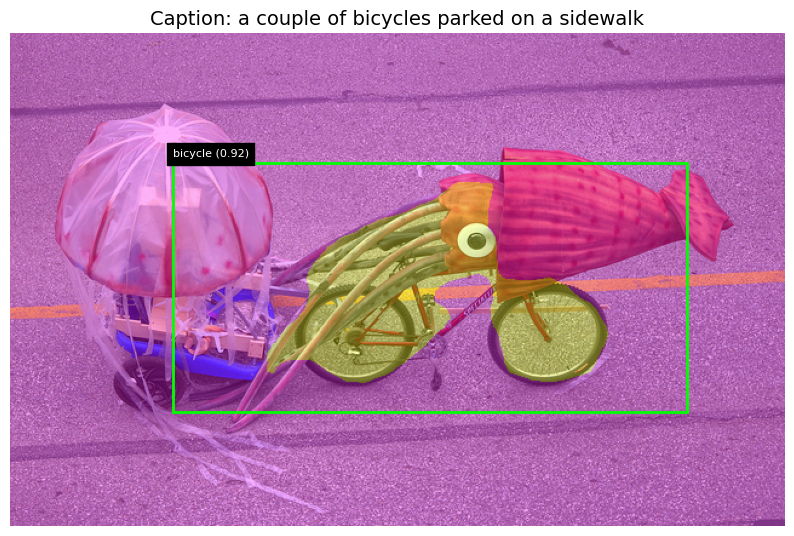

In [55]:
caption_and_segment(
    image_path='/kaggle/input/coco-2017-dataset/coco2017/train2017/000000123456.jpg',
    model_caption=model_caption,
    tokenizer=tokenizer,
    model_segmentation=model_seg,
    device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    max_length=max_len
)